# GARCH + LSTM Hybrid Model for Volatility Forecasting

This notebook implements a hybrid approach combining:
1. **GARCH Model**: Captures volatility clustering and conditional heteroskedasticity
2. **LSTM Neural Network**: Learns complex temporal patterns from volatility predictions

The hybrid model uses GARCH to generate volatility forecasts, then feeds these as features into an LSTM network for improved predictions.

In [35]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from arch import arch_model
import warnings
import random

warnings.filterwarnings('ignore')

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
random.seed(456)
np.random.seed(456)
tf.random.set_seed(456)


## 1. Data Preparation

In [36]:
# Data Download Configuration
# S&P 500: January 1, 2002 to December 31, 2023
# Bitcoin: January 1, 2015 to December 31, 2023

# Define date ranges
sp500_start = "2002-01-01"
sp500_end = "2023-12-31"
bitcoin_start = "2015-01-01"
bitcoin_end = "2023-12-31"

print("Downloading S&P 500 data...")
# Download S&P 500 data (^GSPC is the Yahoo Finance ticker)
sp500_data = yf.download("^GSPC", start=sp500_start, end=sp500_end, progress=False)

print("Downloading Bitcoin data...")
# Download Bitcoin data (BTC-USD is the Yahoo Finance ticker)
bitcoin_data = yf.download("BTC-USD", start=bitcoin_start, end=bitcoin_end, progress=False)

print("Downloading EURUSD data...")
# Download EURUSD data
eurusd_data = yf.download("EURUSD=X", start="2009-08-11", end="2019-08-11", progress=False)

# Display basic information about downloaded data
print(f"\nS&P 500 Data Shape: {sp500_data.shape}")
print(f"S&P 500 Date Range: {sp500_data.index.min()} to {sp500_data.index.max()}")
print(f"Total S&P 500 observations: {len(sp500_data)}")

print(f"\nBitcoin Data Shape: {bitcoin_data.shape}")
print(f"Bitcoin Date Range: {bitcoin_data.index.min()} to {bitcoin_data.index.max()}")
print(f"Total Bitcoin observations: {len(bitcoin_data)}")

print(f"\nEURUSD Data Shape: {eurusd_data.shape}")
print(f"EURUSD Date Range: {eurusd_data.index.min()} to {eurusd_data.index.max()}")
print(f"Total EURUSD observations: {len(eurusd_data)}")



S&P 500 Data Shape: (5537, 5)
S&P 500 Date Range: 2002-01-02 00:00:00 to 2023-12-29 00:00:00
Total S&P 500 observations: 5537

Bitcoin Data Shape: (3286, 5)
Bitcoin Date Range: 2015-01-01 00:00:00 to 2023-12-30 00:00:00
Total Bitcoin observations: 3286

EURUSD Data Shape: (2604, 5)
EURUSD Date Range: 2009-08-11 00:00:00 to 2019-08-09 00:00:00
Total EURUSD observations: 2604


In [37]:
# Calculate log returns
sp500_data['Log_Returns'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))
bitcoin_data['Log_Returns'] = np.log(bitcoin_data['Close'] / bitcoin_data['Close'].shift(1))
eurusd_data['Log_Returns'] = np.log(eurusd_data['Close'] / eurusd_data['Close'].shift(1))

# Calculate realized volatility (squared returns as proxy)
sp500_data['Realized_Volatility'] = sp500_data['Log_Returns'] ** 2
bitcoin_data['Realized_Volatility'] = bitcoin_data['Log_Returns'] ** 2
eurusd_data['Realized_Volatility'] = eurusd_data['Log_Returns'] ** 2

# Drop NaN values
sp500_clean = sp500_data.dropna()
bitcoin_clean = bitcoin_data.dropna()
eurusd_clean = eurusd_data.dropna()

print("\n=== Data Summary ===")
print(f"S&P 500 clean data: {len(sp500_clean)} observations")
print(f"Bitcoin clean data: {len(bitcoin_clean)} observations")
print(f"EURUSD clean data: {len(eurusd_clean)} observations")
print(f"\nS&P 500 Log Returns - Mean: {sp500_clean['Log_Returns'].mean():.6f}, Std: {sp500_clean['Log_Returns'].std():.6f}")
print(f"Bitcoin Log Returns - Mean: {bitcoin_clean['Log_Returns'].mean():.6f}, Std: {bitcoin_clean['Log_Returns'].std():.6f}")
print(f"EURUSD Log Returns - Mean: {eurusd_clean['Log_Returns'].mean():.6f}, Std: {eurusd_clean['Log_Returns'].std():.6f}")


=== Data Summary ===
S&P 500 clean data: 5536 observations
Bitcoin clean data: 3285 observations
EURUSD clean data: 2603 observations

S&P 500 Log Returns - Mean: 0.000256, Std: 0.012245
Bitcoin Log Returns - Mean: 0.001491, Std: 0.037394
EURUSD Log Returns - Mean: -0.000090, Std: 0.005766


## 2. GARCH Model Implementation

We'll use GARCH(1,1) which is the most common specification for financial volatility.

In [38]:
def fit_garch_model(returns, p=1, q=1):
    """
    Fit GARCH model to returns data
    
    Parameters:
    returns: pandas Series of log returns
    p: GARCH lag order
    q: ARCH lag order
    
    Returns:
    fitted model
    """
    # Multiply by 100 to scale the returns (common practice for GARCH estimation)
    returns_scaled = returns * 100
    
    # Specify GARCH model
    model = arch_model(returns_scaled, vol='Garch', p=p, q=q, rescale=False)
    
    # Fit model
    model_fit = model.fit(disp='off')
    
    return model_fit

def get_garch_volatility(model_fit, returns):
    """
    Extract conditional volatility from fitted GARCH model
    """
    # Get conditional volatility (already in percentage scale)
    conditional_vol = model_fit.conditional_volatility / 100
    
    return conditional_vol

In [39]:
# Fit GARCH models for both datasets
print("\n=== Fitting GARCH Models ===")
print("\nFitting GARCH(1,1) for S&P 500...")
sp500_garch = fit_garch_model(sp500_clean['Log_Returns'])
print(sp500_garch.summary())

print("\n" + "="*80)
print("\nFitting GARCH(1,1) for Bitcoin...")
bitcoin_garch = fit_garch_model(bitcoin_clean['Log_Returns'])
print(bitcoin_garch.summary())

print("\n" + "="*80)
print("\nFitting GARCH(1,1) for EURUSD...")
eurusd_garch = fit_garch_model(eurusd_clean['Log_Returns'])
print(eurusd_garch.summary())


=== Fitting GARCH Models ===

Fitting GARCH(1,1) for S&P 500...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7498.89
Distribution:                  Normal   AIC:                           15005.8
Method:            Maximum Likelihood   BIC:                           15032.3
                                        No. Observations:                 5536
Date:                Fri, Dec 12 2025   Df Residuals:                     5535
Time:                        15:41:08   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------

In [40]:
# Extract GARCH conditional volatility
sp500_clean['GARCH_Volatility'] = get_garch_volatility(sp500_garch, sp500_clean['Log_Returns'])
bitcoin_clean['GARCH_Volatility'] = get_garch_volatility(bitcoin_garch, bitcoin_clean['Log_Returns'])
eurusd_clean['GARCH_Volatility'] = get_garch_volatility(eurusd_garch, eurusd_clean['Log_Returns'])

print("\n=== GARCH Volatility Statistics ===")
print(f"S&P 500 GARCH Volatility - Mean: {sp500_clean['GARCH_Volatility'].mean():.6f}, Std: {sp500_clean['GARCH_Volatility'].std():.6f}")
print(f"Bitcoin GARCH Volatility - Mean: {bitcoin_clean['GARCH_Volatility'].mean():.6f}, Std: {bitcoin_clean['GARCH_Volatility'].std():.6f}")
print(f"EURUSD GARCH Volatility - Mean: {eurusd_clean['GARCH_Volatility'].mean():.6f}, Std: {eurusd_clean['GARCH_Volatility'].std():.6f}")


=== GARCH Volatility Statistics ===
S&P 500 GARCH Volatility - Mean: 0.010440, Std: 0.006176
Bitcoin GARCH Volatility - Mean: 0.036201, Std: 0.014206
EURUSD GARCH Volatility - Mean: 0.005608, Std: 0.001440


## 3. LSTM Model Implementation

We'll create LSTM networks that use GARCH volatility predictions as input features to predict future volatility.

In [41]:
def create_lstm_sequences(data, lookback=60):
    """
    Create sequences for LSTM training
    
    Parameters:
    data: array of values to create sequences from
    lookback: number of time steps to look back
    
    Returns:
    X: input sequences
    y: target values
    """
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

def build_lstm_model(lookback, units=50, dropout=0.2):
    """
    Build LSTM model architecture
    """
    model = Sequential()
    
    # First LSTM layer with return sequences
    model.add(LSTM(units=units, return_sequences=True, input_shape=(lookback, 1)))
    model.add(Dropout(dropout))
    
    # Second LSTM layer
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))
    
    # Third LSTM layer
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout))
    
    # Output layer
    model.add(Dense(units=1))
    
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [42]:
def prepare_garch_lstm_data(data, train_split=0.8, lookback=60):
    """
    Prepare data for GARCH-LSTM hybrid model
    """
    # Use GARCH volatility as input feature
    garch_vol = data['GARCH_Volatility'].values.reshape(-1, 1)
    realized_vol = data['Realized_Volatility'].values.reshape(-1, 1)
    
    # Scale the data
    scaler_garch = MinMaxScaler(feature_range=(0, 1))
    scaler_realized = MinMaxScaler(feature_range=(0, 1))
    
    garch_vol_scaled = scaler_garch.fit_transform(garch_vol)
    realized_vol_scaled = scaler_realized.fit_transform(realized_vol)
    
    # Create sequences
    X, y = create_lstm_sequences(garch_vol_scaled, lookback)
    
    # Split into train and test
    train_size = int(len(X) * train_split)
    
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]
    
    # Reshape for LSTM [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Get corresponding realized volatility for comparison
    y_realized_train = realized_vol_scaled[lookback:lookback+train_size]
    y_realized_test = realized_vol_scaled[lookback+train_size:]
    
    return X_train, X_test, y_train, y_test, y_realized_train, y_realized_test, scaler_garch, scaler_realized

## 4. Train GARCH-LSTM Hybrid Models

In [43]:
# Prepare data for S&P 500
print("\n=== Preparing S&P 500 Data for GARCH-LSTM ===")
lookback = 60
X_train_sp, X_test_sp, y_train_sp, y_test_sp, y_real_train_sp, y_real_test_sp, scaler_garch_sp, scaler_real_sp = prepare_garch_lstm_data(
    sp500_clean, train_split=0.8, lookback=lookback
)

print(f"Training set size: {X_train_sp.shape[0]}")
print(f"Test set size: {X_test_sp.shape[0]}")
print(f"Lookback period: {lookback} days")

# Build and train S&P 500 model
print("\n=== Training S&P 500 GARCH-LSTM Model ===")
model_sp = build_lstm_model(lookback=lookback, units=50, dropout=0.2)
print(model_sp.summary())

history_sp = model_sp.fit(
    X_train_sp, y_train_sp,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


=== Preparing S&P 500 Data for GARCH-LSTM ===
Training set size: 4380
Test set size: 1096
Lookback period: 60 days

=== Training S&P 500 GARCH-LSTM Model ===


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0011 - val_loss: 9.3373e-04
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 8.9486e-04 - val_loss: 7.7822e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 8.4553e-04 - val_loss: 7.3952e-04
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 8.1579e-04 - val_loss: 6.8879e-04
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 7.5961e-04 - val_loss: 6.1635e-04
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 6.8489e-04 - val_loss: 5.6048e-04
Epoch 9/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 6.2595e-04 - val_loss: 4.9566e-04
Epoch 10/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 6.1885e-04 - val_loss: 4.7945e-04
Epoch 11/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 5.

In [44]:
# Prepare data for Bitcoin
print("\n=== Preparing Bitcoin Data for GARCH-LSTM ===")
X_train_btc, X_test_btc, y_train_btc, y_test_btc, y_real_train_btc, y_real_test_btc, scaler_garch_btc, scaler_real_btc = prepare_garch_lstm_data(
    bitcoin_clean, train_split=0.8, lookback=lookback
)

print(f"Training set size: {X_train_btc.shape[0]}")
print(f"Test set size: {X_test_btc.shape[0]}")
print(f"Lookback period: {lookback} days")

# Build and train Bitcoin model
print("\n=== Training Bitcoin GARCH-LSTM Model ===")
model_btc = build_lstm_model(lookback=lookback, units=50, dropout=0.2)
print(model_btc.summary())

history_btc = model_btc.fit(
    X_train_btc, y_train_btc,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


=== Preparing Bitcoin Data for GARCH-LSTM ===
Training set size: 2580
Test set size: 645
Lookback period: 60 days

=== Training Bitcoin GARCH-LSTM Model ===


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0067 - val_loss: 0.0017
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0041 - val_loss: 0.0014
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0022 - val_loss: 9.2612e-04
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0019 - val_loss: 9.6547e-04
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0019 - val_loss: 8.2948e-04
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0017 - val_loss: 7.9977e-04
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0015 - val_loss: 7.2655e-04
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━

In [45]:
# Prepare data for EURUSD
print("\n=== Preparing EURUSD Data for GARCH-LSTM ===")
X_train_eurusd, X_test_eurusd, y_train_eurusd, y_test_eurusd, y_real_train_eurusd, y_real_test_eurusd, scaler_garch_eurusd, scaler_real_eurusd = prepare_garch_lstm_data(
    eurusd_clean, train_split=0.8, lookback=lookback
)

print(f"Training set size: {X_train_eurusd.shape[0]}")
print(f"Test set size: {X_test_eurusd.shape[0]}")
print(f"Lookback period: {lookback} days")

# Build and train EURUSD model
print("\n=== Training EURUSD GARCH-LSTM Model ===")
model_eurusd = build_lstm_model(lookback=lookback, units=50, dropout=0.2)
print(model_eurusd.summary())

history_eurusd = model_eurusd.fit(
    X_train_eurusd, y_train_eurusd,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


=== Preparing EURUSD Data for GARCH-LSTM ===
Training set size: 2034
Test set size: 509
Lookback period: 60 days

=== Training EURUSD GARCH-LSTM Model ===


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0217 - val_loss: 0.0026
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0072 - val_loss: 0.0022
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0066 - val_loss: 0.0020
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0061 - val_loss: 0.0017
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0057 - val_loss: 0.0016
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0053 - val_loss: 0.0025
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0050 - val_loss: 0.0014
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss

## 5. Model Predictions and Performance Metrics

In [46]:
# Make predictions for S&P 500
print("\n=== Making Predictions for S&P 500 ===")
y_pred_train_sp = model_sp.predict(X_train_sp)
y_pred_test_sp = model_sp.predict(X_test_sp)

# Inverse transform predictions to original scale
y_pred_train_sp_orig = scaler_garch_sp.inverse_transform(y_pred_train_sp)
y_pred_test_sp_orig = scaler_garch_sp.inverse_transform(y_pred_test_sp.reshape(-1, 1))
y_train_sp_orig = scaler_garch_sp.inverse_transform(y_train_sp.reshape(-1, 1))
y_test_sp_orig = scaler_garch_sp.inverse_transform(y_test_sp.reshape(-1, 1))

# Get realized volatility for comparison
y_real_train_sp_orig = scaler_real_sp.inverse_transform(y_real_train_sp)
y_real_test_sp_orig = scaler_real_sp.inverse_transform(y_real_test_sp)

# Calculate metrics for S&P 500
rmse_train_sp = np.sqrt(mean_squared_error(y_real_train_sp_orig, y_pred_train_sp_orig))
mae_train_sp = mean_absolute_error(y_real_train_sp_orig, y_pred_train_sp_orig)
rmse_test_sp = np.sqrt(mean_squared_error(y_real_test_sp_orig, y_pred_test_sp_orig))
mae_test_sp = mean_absolute_error(y_real_test_sp_orig, y_pred_test_sp_orig)

# Calculate GARCH-only performance for comparison
rmse_garch_train_sp = np.sqrt(mean_squared_error(y_real_train_sp_orig, y_train_sp_orig))
mae_garch_train_sp = mean_absolute_error(y_real_train_sp_orig, y_train_sp_orig)
rmse_garch_test_sp = np.sqrt(mean_squared_error(y_real_test_sp_orig, y_test_sp_orig))
mae_garch_test_sp = mean_absolute_error(y_real_test_sp_orig, y_test_sp_orig)

print("\n=== S&P 500 Performance Metrics ===")
print("\nGARCH-LSTM Hybrid Model:")
print(f"Training Set - RMSE: {rmse_train_sp:.8f}, MAE: {mae_train_sp:.8f}")
print(f"Test Set - RMSE: {rmse_test_sp:.8f}, MAE: {mae_test_sp:.8f}")
print("\nGARCH Model (Baseline):")
print(f"Training Set - RMSE: {rmse_garch_train_sp:.8f}, MAE: {mae_garch_train_sp:.8f}")
print(f"Test Set - RMSE: {rmse_garch_test_sp:.8f}, MAE: {mae_garch_test_sp:.8f}")
print("\nImprovement over GARCH:")
print(f"Test RMSE Improvement: {((rmse_garch_test_sp - rmse_test_sp) / rmse_garch_test_sp * 100):.2f}%")
print(f"Test MAE Improvement: {((mae_garch_test_sp - mae_test_sp) / mae_garch_test_sp * 100):.2f}%")


=== Making Predictions for S&P 500 ===
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

=== S&P 500 Performance Metrics ===

GARCH-LSTM Hybrid Model:
Training Set - RMSE: 0.01168925, MAE: 0.01038936
Test Set - RMSE: 0.01347338, MAE: 0.01172779

GARCH Model (Baseline):
Training Set - RMSE: 0.01147896, MAE: 0.01000530
Test Set - RMSE: 0.01339411, MAE: 0.01140869

Improvement over GARCH:
Test RMSE Improvement: -0.59%
Test MAE Improvement: -2.80%


In [47]:
# Make predictions for Bitcoin
print("\n=== Making Predictions for Bitcoin ===")
y_pred_train_btc = model_btc.predict(X_train_btc)
y_pred_test_btc = model_btc.predict(X_test_btc)

# Inverse transform predictions to original scale
y_pred_train_btc_orig = scaler_garch_btc.inverse_transform(y_pred_train_btc)
y_pred_test_btc_orig = scaler_garch_btc.inverse_transform(y_pred_test_btc.reshape(-1, 1))
y_train_btc_orig = scaler_garch_btc.inverse_transform(y_train_btc.reshape(-1, 1))
y_test_btc_orig = scaler_garch_btc.inverse_transform(y_test_btc.reshape(-1, 1))

# Get realized volatility for comparison
y_real_train_btc_orig = scaler_real_btc.inverse_transform(y_real_train_btc)
y_real_test_btc_orig = scaler_real_btc.inverse_transform(y_real_test_btc)

# Calculate metrics for Bitcoin
rmse_train_btc = np.sqrt(mean_squared_error(y_real_train_btc_orig, y_pred_train_btc_orig))
mae_train_btc = mean_absolute_error(y_real_train_btc_orig, y_pred_train_btc_orig)
rmse_test_btc = np.sqrt(mean_squared_error(y_real_test_btc_orig, y_pred_test_btc_orig))
mae_test_btc = mean_absolute_error(y_real_test_btc_orig, y_pred_test_btc_orig)

# Calculate GARCH-only performance for comparison
rmse_garch_train_btc = np.sqrt(mean_squared_error(y_real_train_btc_orig, y_train_btc_orig))
mae_garch_train_btc = mean_absolute_error(y_real_train_btc_orig, y_train_btc_orig)
rmse_garch_test_btc = np.sqrt(mean_squared_error(y_real_test_btc_orig, y_test_btc_orig))
mae_garch_test_btc = mean_absolute_error(y_real_test_btc_orig, y_test_btc_orig)

print("\n=== Bitcoin Performance Metrics ===")
print("\nGARCH-LSTM Hybrid Model:")
print(f"Training Set - RMSE: {rmse_train_btc:.8f}, MAE: {mae_train_btc:.8f}")
print(f"Test Set - RMSE: {rmse_test_btc:.8f}, MAE: {mae_test_btc:.8f}")
print("\nGARCH Model (Baseline):")
print(f"Training Set - RMSE: {rmse_garch_train_btc:.8f}, MAE: {mae_garch_train_btc:.8f}")
print(f"Test Set - RMSE: {rmse_garch_test_btc:.8f}, MAE: {mae_garch_test_btc:.8f}")
print("\nImprovement over GARCH:")
print(f"Test RMSE Improvement: {((rmse_garch_test_btc - rmse_test_btc) / rmse_garch_test_btc * 100):.2f}%")
print(f"Test MAE Improvement: {((mae_garch_test_btc - mae_test_btc) / mae_garch_test_btc * 100):.2f}%")


=== Making Predictions for Bitcoin ===
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

=== Bitcoin Performance Metrics ===

GARCH-LSTM Hybrid Model:
Training Set - RMSE: 0.03703890, MAE: 0.03456104
Test Set - RMSE: 0.03004786, MAE: 0.02893437

GARCH Model (Baseline):
Training Set - RMSE: 0.03850189, MAE: 0.03576938
Test Set - RMSE: 0.03090664, MAE: 0.02972963

Improvement over GARCH:
Test RMSE Improvement: 2.78%
Test MAE Improvement: 2.67%


In [48]:
# Make predictions for EURUSD
print("\n=== Making Predictions for EURUSD ===")
y_pred_train_eurusd = model_eurusd.predict(X_train_eurusd)
y_pred_test_eurusd = model_eurusd.predict(X_test_eurusd)

# Inverse transform predictions to original scale
y_pred_train_eurusd_orig = scaler_garch_eurusd.inverse_transform(y_pred_train_eurusd)
y_pred_test_eurusd_orig = scaler_garch_eurusd.inverse_transform(y_pred_test_eurusd.reshape(-1, 1))
y_train_eurusd_orig = scaler_garch_eurusd.inverse_transform(y_train_eurusd.reshape(-1, 1))
y_test_eurusd_orig = scaler_garch_eurusd.inverse_transform(y_test_eurusd.reshape(-1, 1))

# Get realized volatility for comparison
y_real_train_eurusd_orig = scaler_real_eurusd.inverse_transform(y_real_train_eurusd)
y_real_test_eurusd_orig = scaler_real_eurusd.inverse_transform(y_real_test_eurusd)

# Calculate metrics for Bitcoin
rmse_train_eurusd = np.sqrt(mean_squared_error(y_real_train_eurusd_orig, y_pred_train_eurusd_orig))
mae_train_eurusd = mean_absolute_error(y_real_train_eurusd_orig, y_pred_train_eurusd_orig)
rmse_test_eurusd = np.sqrt(mean_squared_error(y_real_test_eurusd_orig, y_pred_test_eurusd_orig))
mae_test_eurusd = mean_absolute_error(y_real_test_eurusd_orig, y_pred_test_eurusd_orig)

# Calculate GARCH-only performance for comparison
rmse_garch_train_eurusd = np.sqrt(mean_squared_error(y_real_train_eurusd_orig, y_train_eurusd_orig))
mae_garch_train_eurusd = mean_absolute_error(y_real_train_eurusd_orig, y_train_eurusd_orig)
rmse_garch_test_eurusd = np.sqrt(mean_squared_error(y_real_test_eurusd_orig, y_test_eurusd_orig))
mae_garch_test_eurusd = mean_absolute_error(y_real_test_eurusd_orig, y_test_eurusd_orig)

print("\n=== EURUSD Performance Metrics ===")
print("\nGARCH-LSTM Hybrid Model:")
print(f"Training Set - RMSE: {rmse_train_eurusd:.8f}, MAE: {mae_train_eurusd:.8f}")
print(f"Test Set - RMSE: {rmse_test_eurusd:.8f}, MAE: {mae_test_eurusd:.8f}")
print("\nGARCH Model (Baseline):")
print(f"Training Set - RMSE: {rmse_garch_train_eurusd:.8f}, MAE: {mae_garch_train_eurusd:.8f}")
print(f"Test Set - RMSE: {rmse_garch_test_eurusd:.8f}, MAE: {mae_garch_test_eurusd:.8f}")
print("\nImprovement over GARCH:")
print(f"Test RMSE Improvement: {((rmse_garch_test_eurusd - rmse_test_eurusd) / rmse_garch_test_eurusd * 100):.2f}%")
print(f"Test MAE Improvement: {((mae_garch_test_eurusd - mae_test_eurusd) / mae_garch_test_eurusd * 100):.2f}%")


=== Making Predictions for EURUSD ===
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

=== EURUSD Performance Metrics ===

GARCH-LSTM Hybrid Model:
Training Set - RMSE: 0.00603269, MAE: 0.00586280
Test Set - RMSE: 0.00435397, MAE: 0.00432170

GARCH Model (Baseline):
Training Set - RMSE: 0.00607034, MAE: 0.00589977
Test Set - RMSE: 0.00439198, MAE: 0.00436057

Improvement over GARCH:
Test RMSE Improvement: 0.87%
Test MAE Improvement: 0.89%


## 6. Visualizations

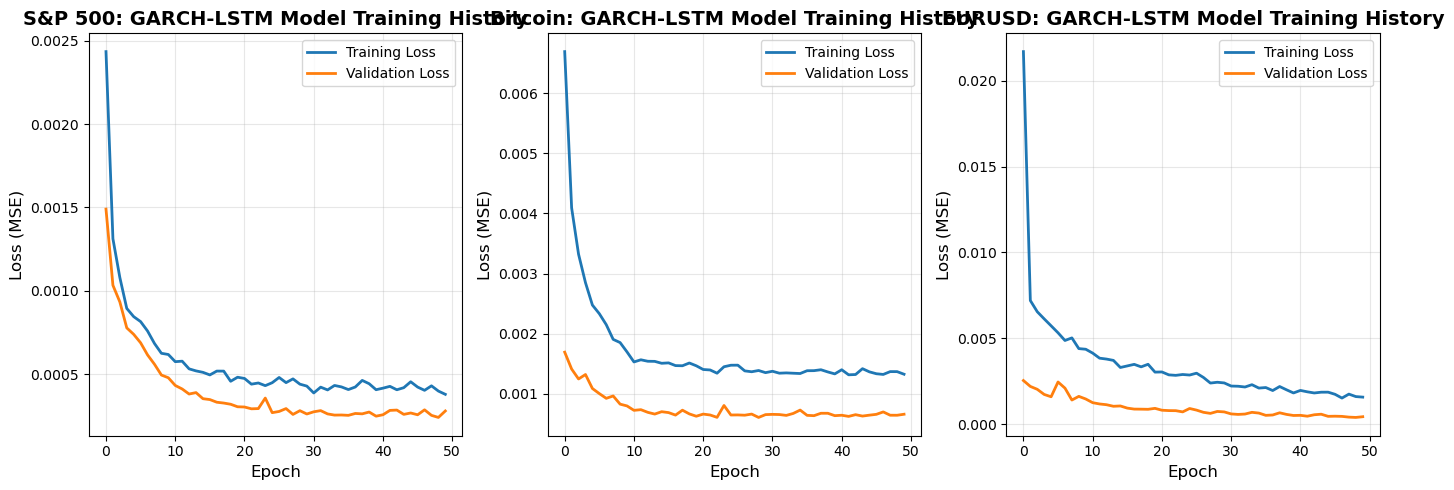

In [49]:
# Plot training history for S&P 500
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(history_sp.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_sp.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('S&P 500: GARCH-LSTM Model Training History', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history_btc.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_btc.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Bitcoin: GARCH-LSTM Model Training History', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(history_eurusd.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_eurusd.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('EURUSD: GARCH-LSTM Model Training History', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)


plt.tight_layout()
# plt.savefig('garch_lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# print("Training history plot saved as 'garch_lstm_training_history.png'")

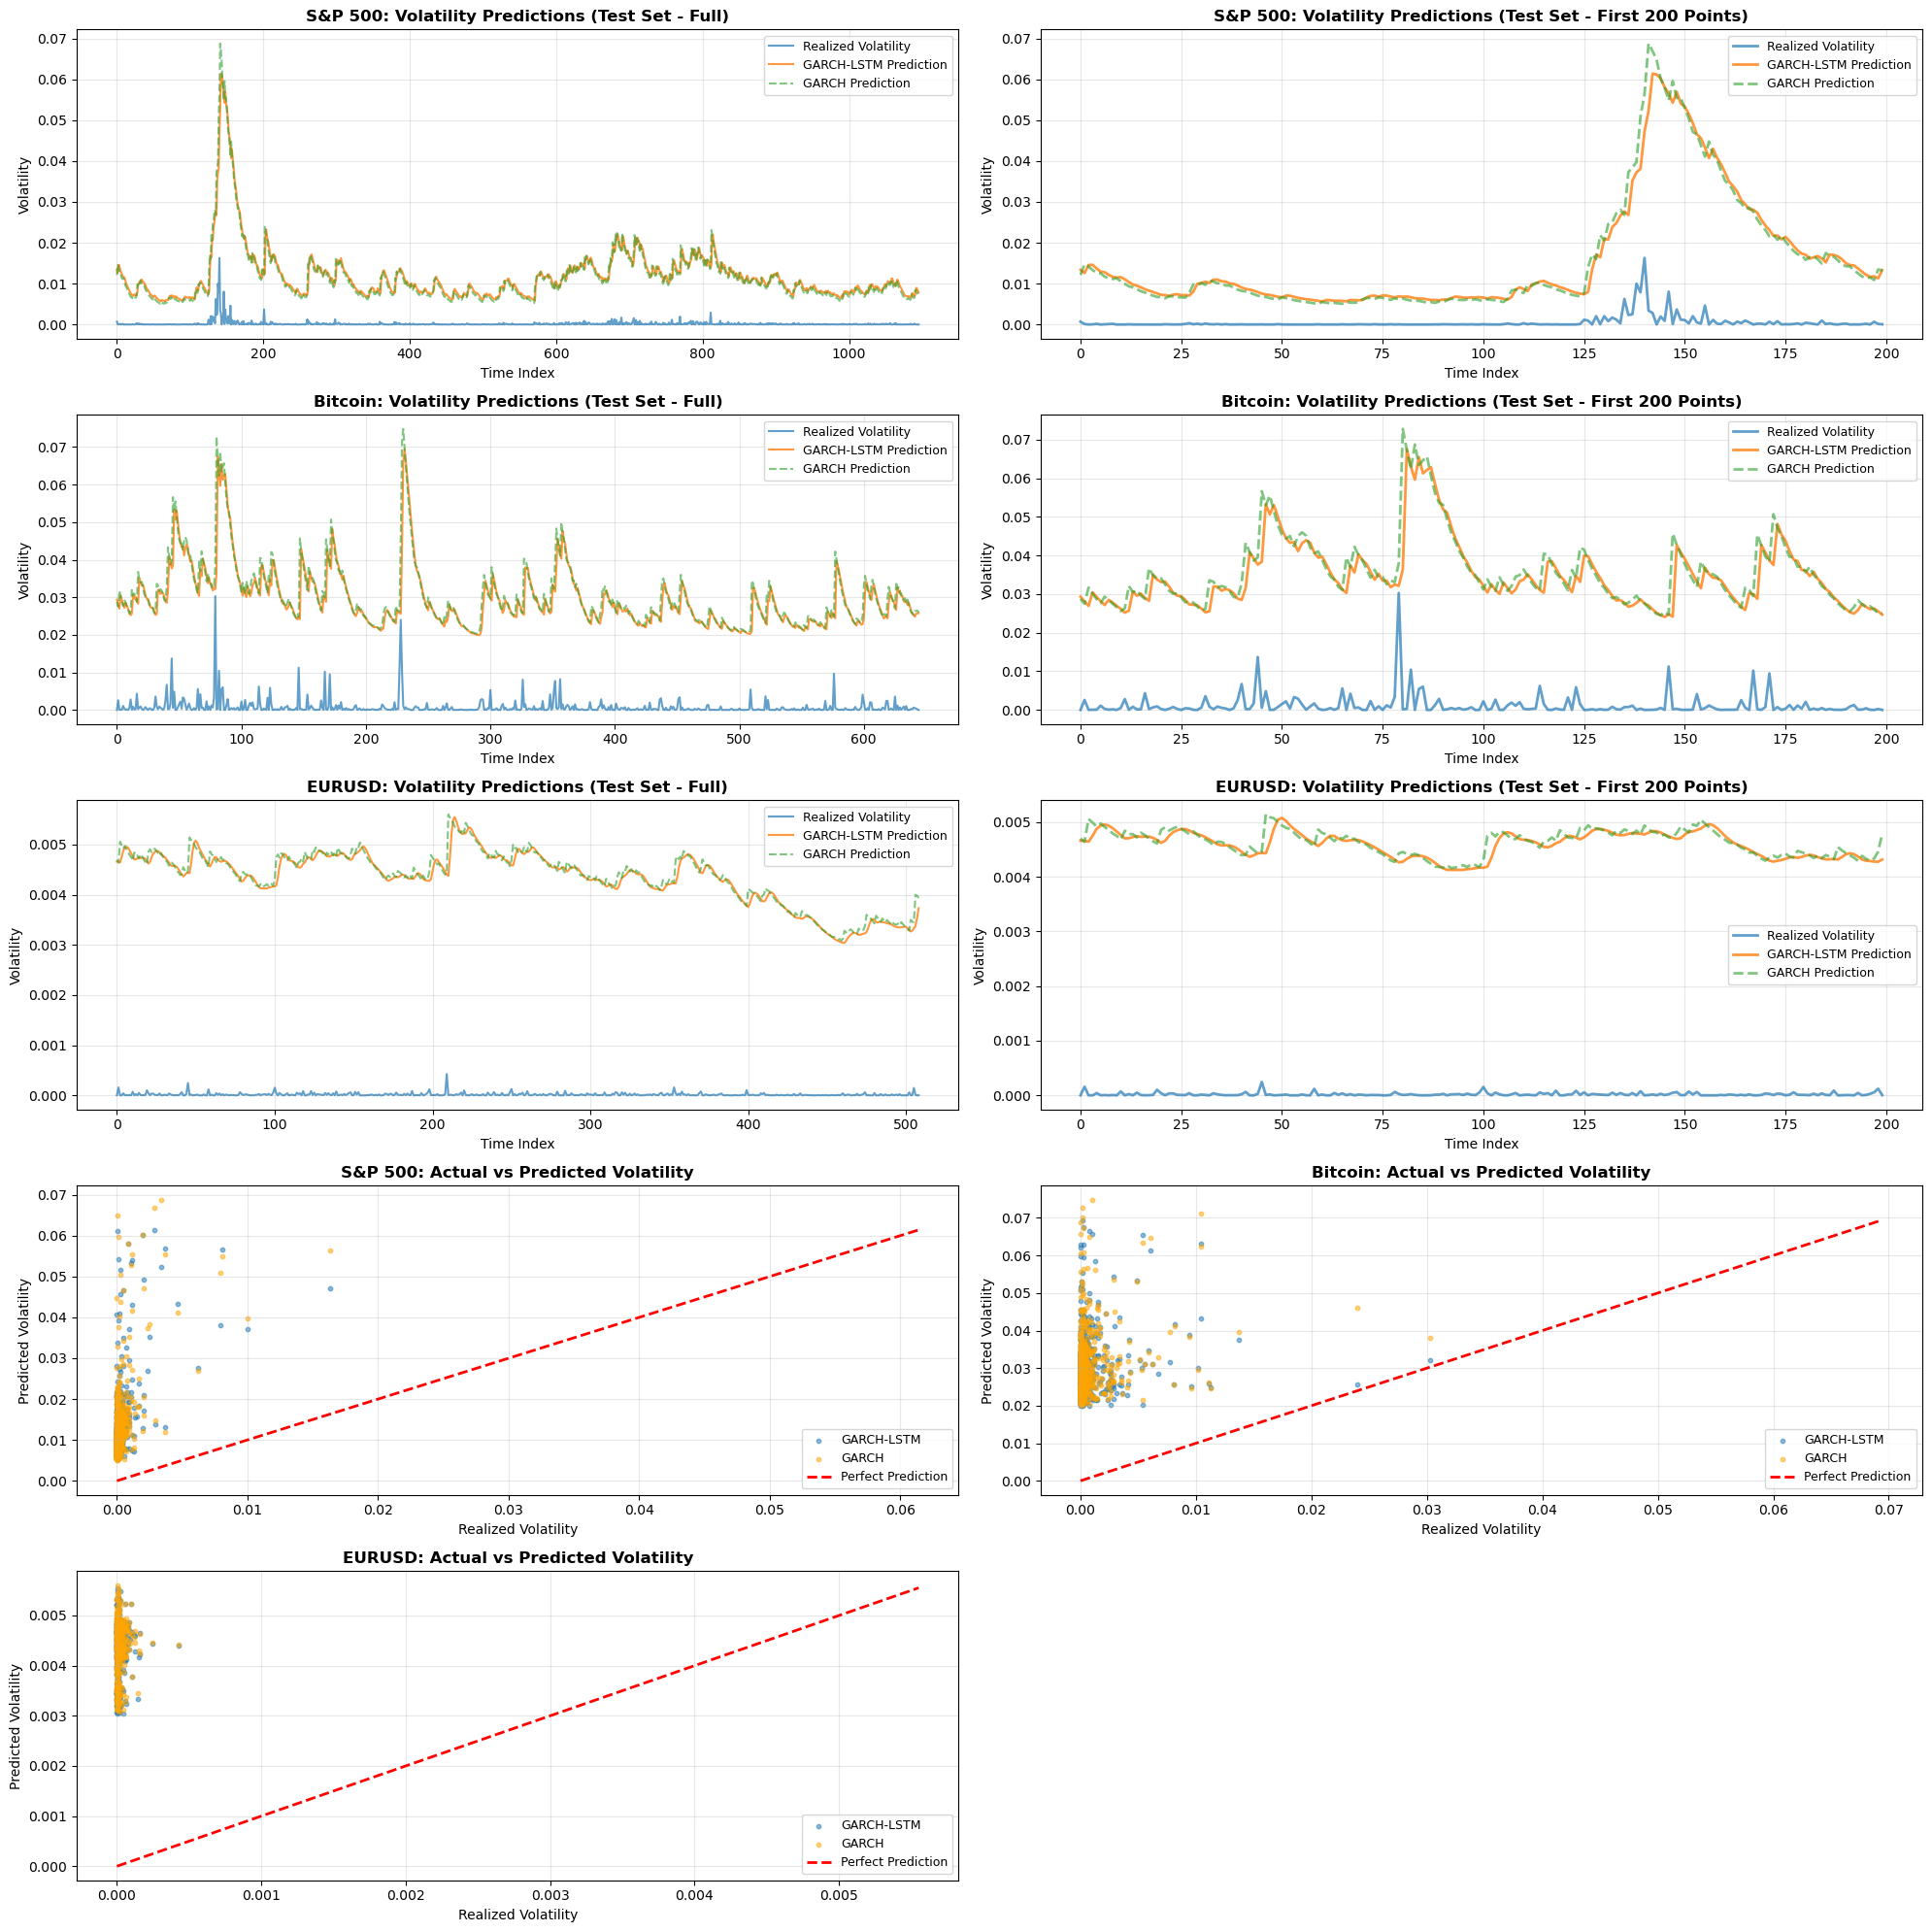

In [50]:
# Plot predictions vs actual for S&P 500
plt.figure(figsize=(20, 20))

# S&P 500 - Full Period
plt.subplot(5, 2, 1)
plt.plot(y_real_test_sp_orig, label='Realized Volatility', alpha=0.7, linewidth=1.5)
plt.plot(y_pred_test_sp_orig, label='GARCH-LSTM Prediction', alpha=0.8, linewidth=1.5)
plt.plot(y_test_sp_orig, label='GARCH Prediction', alpha=0.6, linewidth=1.5, linestyle='--')
plt.title('S&P 500: Volatility Predictions (Test Set - Full)', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Volatility', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# S&P 500 - Zoomed (first 200 points)
plt.subplot(5, 2, 2)
zoom_points = min(200, len(y_real_test_sp_orig))
plt.plot(y_real_test_sp_orig[:zoom_points], label='Realized Volatility', alpha=0.7, linewidth=2)
plt.plot(y_pred_test_sp_orig[:zoom_points], label='GARCH-LSTM Prediction', alpha=0.8, linewidth=2)
plt.plot(y_test_sp_orig[:zoom_points], label='GARCH Prediction', alpha=0.6, linewidth=2, linestyle='--')
plt.title(f'S&P 500: Volatility Predictions (Test Set - First {zoom_points} Points)', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Volatility', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Bitcoin - Full Period
plt.subplot(5, 2, 3)
plt.plot(y_real_test_btc_orig, label='Realized Volatility', alpha=0.7, linewidth=1.5)
plt.plot(y_pred_test_btc_orig, label='GARCH-LSTM Prediction', alpha=0.8, linewidth=1.5)
plt.plot(y_test_btc_orig, label='GARCH Prediction', alpha=0.6, linewidth=1.5, linestyle='--')
plt.title('Bitcoin: Volatility Predictions (Test Set - Full)', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Volatility', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Bitcoin - Zoomed (first 200 points)
plt.subplot(5, 2, 4)
zoom_points_btc = min(200, len(y_real_test_btc_orig))
plt.plot(y_real_test_btc_orig[:zoom_points_btc], label='Realized Volatility', alpha=0.7, linewidth=2)
plt.plot(y_pred_test_btc_orig[:zoom_points_btc], label='GARCH-LSTM Prediction', alpha=0.8, linewidth=2)
plt.plot(y_test_btc_orig[:zoom_points_btc], label='GARCH Prediction', alpha=0.6, linewidth=2, linestyle='--')
plt.title(f'Bitcoin: Volatility Predictions (Test Set - First {zoom_points_btc} Points)', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Volatility', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# EURUSD - Full Period
plt.subplot(5, 2, 5)
plt.plot(y_real_test_eurusd_orig, label='Realized Volatility', alpha=0.7, linewidth=1.5)
plt.plot(y_pred_test_eurusd_orig, label='GARCH-LSTM Prediction', alpha=0.8, linewidth=1.5)
plt.plot(y_test_eurusd_orig, label='GARCH Prediction', alpha=0.6, linewidth=1.5, linestyle='--')
plt.title('EURUSD: Volatility Predictions (Test Set - Full)', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Volatility', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# EURUSD - Zoomed (first 200 points)
plt.subplot(5, 2, 6)
zoom_points_eurusd = min(200, len(y_real_test_eurusd_orig))
plt.plot(y_real_test_eurusd_orig[:zoom_points_eurusd], label='Realized Volatility', alpha=0.7, linewidth=2)
plt.plot(y_pred_test_eurusd_orig[:zoom_points_eurusd], label='GARCH-LSTM Prediction', alpha=0.8, linewidth=2)
plt.plot(y_test_eurusd_orig[:zoom_points_eurusd], label='GARCH Prediction', alpha=0.6, linewidth=2, linestyle='--')
plt.title(f'EURUSD: Volatility Predictions (Test Set - First {zoom_points_eurusd} Points)', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Volatility', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# S&P 500 Scatter Plot
plt.subplot(5, 2, 7)
plt.scatter(y_real_test_sp_orig, y_pred_test_sp_orig, alpha=0.5, s=10, label='GARCH-LSTM')
plt.scatter(y_real_test_sp_orig, y_test_sp_orig, alpha=0.5, s=10, label='GARCH', color='orange')
min_val = min(y_real_test_sp_orig.min(), y_pred_test_sp_orig.min())
max_val = max(y_real_test_sp_orig.max(), y_pred_test_sp_orig.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
plt.title('S&P 500: Actual vs Predicted Volatility', fontsize=12, fontweight='bold')
plt.xlabel('Realized Volatility', fontsize=10)
plt.ylabel('Predicted Volatility', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Bitcoin Scatter Plot
plt.subplot(5, 2, 8)
plt.scatter(y_real_test_btc_orig, y_pred_test_btc_orig, alpha=0.5, s=10, label='GARCH-LSTM')
plt.scatter(y_real_test_btc_orig, y_test_btc_orig, alpha=0.5, s=10, label='GARCH', color='orange')
min_val_btc = min(y_real_test_btc_orig.min(), y_pred_test_btc_orig.min())
max_val_btc = max(y_real_test_btc_orig.max(), y_pred_test_btc_orig.max())
plt.plot([min_val_btc, max_val_btc], [min_val_btc, max_val_btc], 'r--', linewidth=2, label='Perfect Prediction')
plt.title('Bitcoin: Actual vs Predicted Volatility', fontsize=12, fontweight='bold')
plt.xlabel('Realized Volatility', fontsize=10)
plt.ylabel('Predicted Volatility', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.subplot(5, 2, 9)
plt.scatter(y_real_test_eurusd_orig, y_pred_test_eurusd_orig, alpha=0.5, s=10, label='GARCH-LSTM')
plt.scatter(y_real_test_eurusd_orig, y_test_eurusd_orig, alpha=0.5, s=10, label='GARCH', color='orange')
min_val_eurusd = min(y_real_test_eurusd_orig.min(), y_pred_test_eurusd_orig.min())
max_val_eurusd = max(y_real_test_eurusd_orig.max(), y_pred_test_eurusd_orig.max())
plt.plot([min_val_eurusd, max_val_eurusd], [min_val_eurusd, max_val_eurusd], 'r--', linewidth=2, label='Perfect Prediction')
plt.title('EURUSD: Actual vs Predicted Volatility', fontsize=12, fontweight='bold')
plt.xlabel('Realized Volatility', fontsize=10)
plt.ylabel('Predicted Volatility', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)


plt.tight_layout()
# plt.savefig('garch_lstm_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# print("Prediction plots saved as 'garch_lstm_predictions.png'")

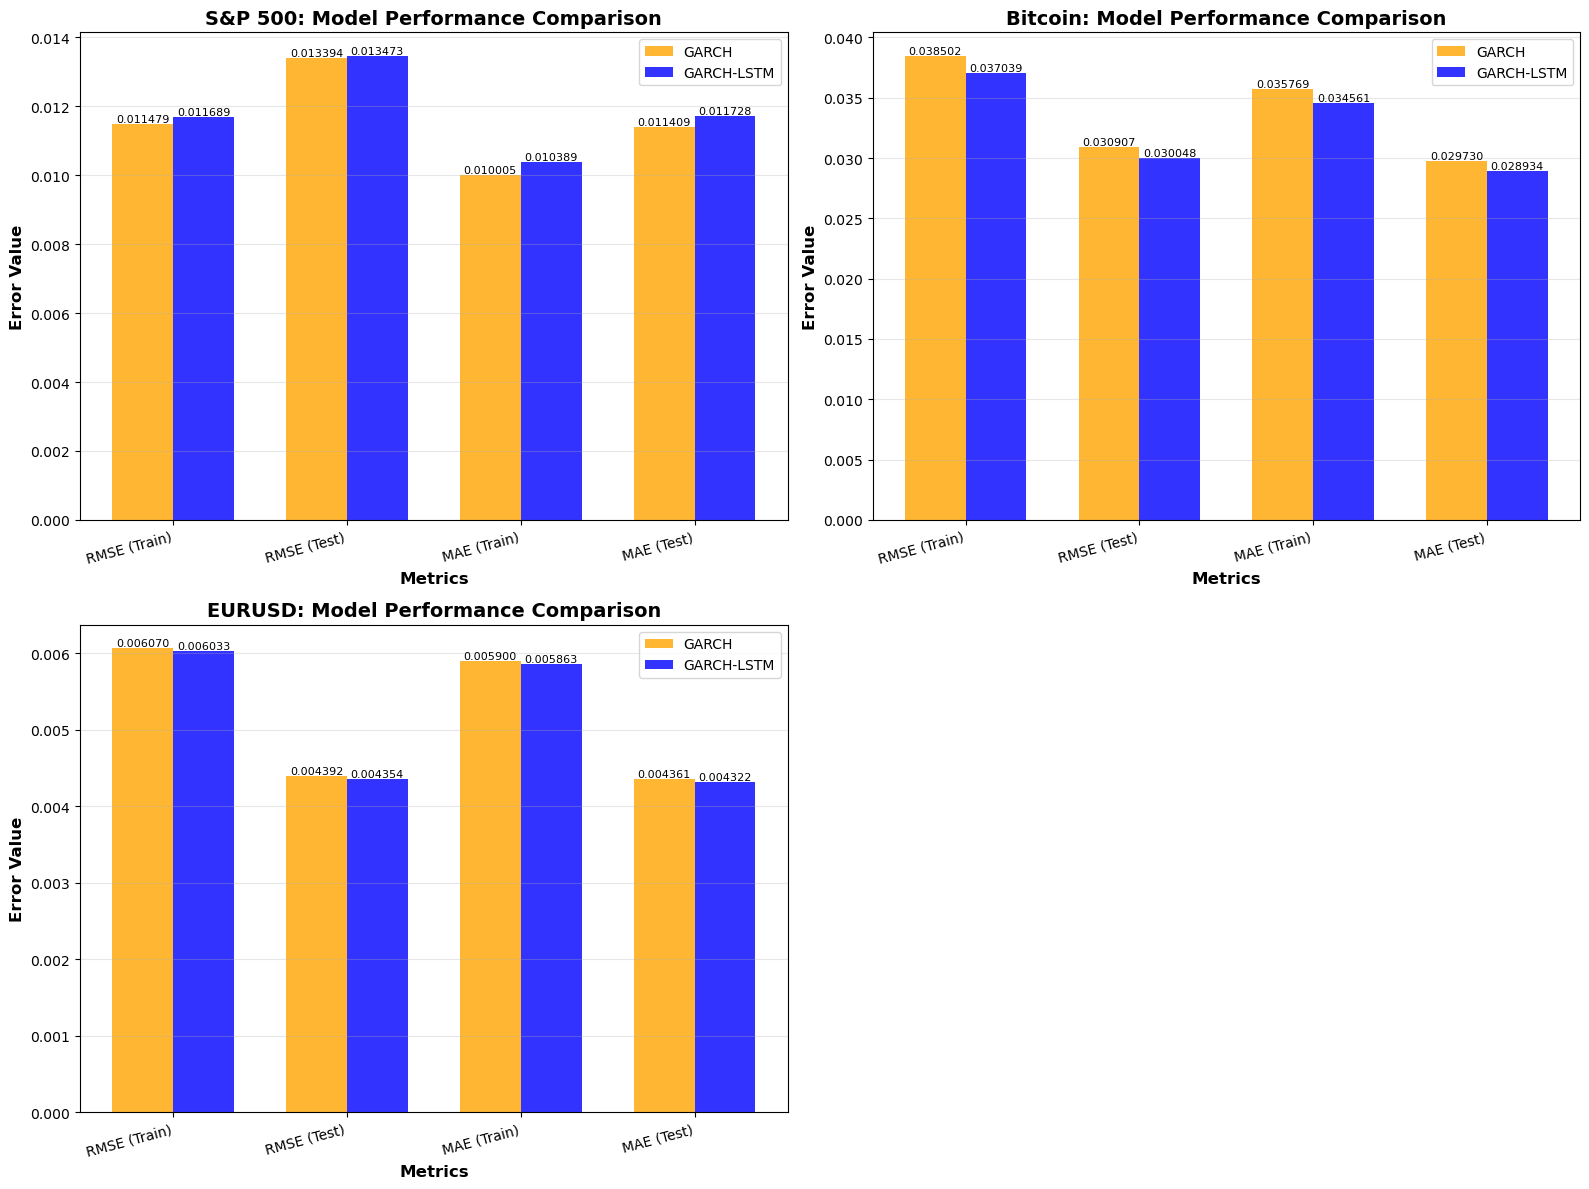

In [51]:
# Create performance comparison bar chart
plt.figure(figsize=(16, 12))

# S&P 500 Metrics
plt.subplot(2, 2, 1)
metrics = ['RMSE (Train)', 'RMSE (Test)', 'MAE (Train)', 'MAE (Test)']
garch_lstm_values = [rmse_train_sp, rmse_test_sp, mae_train_sp, mae_test_sp]
garch_values = [rmse_garch_train_sp, rmse_garch_test_sp, mae_garch_train_sp, mae_garch_test_sp]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, garch_values, width, label='GARCH', alpha=0.8, color='orange')
plt.bar(x + width/2, garch_lstm_values, width, label='GARCH-LSTM', alpha=0.8, color='blue')

plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Error Value', fontsize=12, fontweight='bold')
plt.title('S&P 500: Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, metrics, rotation=15, ha='right')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (g, gl) in enumerate(zip(garch_values, garch_lstm_values)):
    plt.text(i - width/2, g, f'{g:.6f}', ha='center', va='bottom', fontsize=8)
    plt.text(i + width/2, gl, f'{gl:.6f}', ha='center', va='bottom', fontsize=8)

# Bitcoin Metrics
plt.subplot(2, 2, 2)
garch_lstm_values_btc = [rmse_train_btc, rmse_test_btc, mae_train_btc, mae_test_btc]
garch_values_btc = [rmse_garch_train_btc, rmse_garch_test_btc, mae_garch_train_btc, mae_garch_test_btc]

plt.bar(x - width/2, garch_values_btc, width, label='GARCH', alpha=0.8, color='orange')
plt.bar(x + width/2, garch_lstm_values_btc, width, label='GARCH-LSTM', alpha=0.8, color='blue')

plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Error Value', fontsize=12, fontweight='bold')
plt.title('Bitcoin: Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, metrics, rotation=15, ha='right')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (g, gl) in enumerate(zip(garch_values_btc, garch_lstm_values_btc)):
    plt.text(i - width/2, g, f'{g:.6f}', ha='center', va='bottom', fontsize=8)
    plt.text(i + width/2, gl, f'{gl:.6f}', ha='center', va='bottom', fontsize=8)


# EURUSD Metrics
plt.subplot(2, 2, 3)
garch_lstm_values_eurusd = [rmse_train_eurusd, rmse_test_eurusd, mae_train_eurusd, mae_test_eurusd]
garch_values_eurusd = [rmse_garch_train_eurusd, rmse_garch_test_eurusd, mae_garch_train_eurusd, mae_garch_test_eurusd]

plt.bar(x - width/2, garch_values_eurusd, width, label='GARCH', alpha=0.8, color='orange')
plt.bar(x + width/2, garch_lstm_values_eurusd, width, label='GARCH-LSTM', alpha=0.8, color='blue')

plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Error Value', fontsize=12, fontweight='bold')
plt.title('EURUSD: Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, metrics, rotation=15, ha='right')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (g, gl) in enumerate(zip(garch_values_eurusd, garch_lstm_values_eurusd)):
    plt.text(i - width/2, g, f'{g:.6f}', ha='center', va='bottom', fontsize=8)
    plt.text(i + width/2, gl, f'{gl:.6f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
# plt.savefig('garch_lstm_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# print("Performance comparison plot saved as 'garch_lstm_performance_comparison.png'")

In [52]:
# Create a summary table
summary_data = {
    'Model': ['GARCH', 'GARCH-LSTM', 'Improvement (%)'],
    'S&P 500 Test RMSE': [
        f'{rmse_garch_test_sp:.8f}',
        f'{rmse_test_sp:.8f}',
        f'{((rmse_garch_test_sp - rmse_test_sp) / rmse_garch_test_sp * 100):.2f}%'
    ],
    'S&P 500 Test MAE': [
        f'{mae_garch_test_sp:.8f}',
        f'{mae_test_sp:.8f}',
        f'{((mae_garch_test_sp - mae_test_sp) / mae_garch_test_sp * 100):.2f}%'
    ],
    'Bitcoin Test RMSE': [
        f'{rmse_garch_test_btc:.8f}',
        f'{rmse_test_btc:.8f}',
        f'{((rmse_garch_test_btc - rmse_test_btc) / rmse_garch_test_btc * 100):.2f}%'
    ],
    'Bitcoin Test MAE': [
        f'{mae_garch_test_btc:.8f}',
        f'{mae_test_btc:.8f}',
        f'{((mae_garch_test_btc - mae_test_btc) / mae_garch_test_btc * 100):.2f}%'
    ],
    'EURUSD Test RMSE': [
        f'{rmse_garch_test_eurusd:.8f}',
        f'{rmse_test_eurusd:.8f}',
        f'{((rmse_garch_test_eurusd - rmse_test_eurusd) / rmse_garch_test_eurusd * 100):.2f}%'
    ],
    'EURUSD Test MAE': [
        f'{mae_garch_test_eurusd:.8f}',
        f'{mae_test_eurusd:.8f}',
        f'{((mae_garch_test_eurusd - mae_test_eurusd) / mae_garch_test_eurusd * 100):.2f}%'
    ],
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*100)
print("GARCH-LSTM HYBRID MODEL: PERFORMANCE SUMMARY")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)

# Save summary to CSV
summary_df.to_csv('garch_lstm_performance_summary.csv', index=False)
print("\nPerformance summary saved as 'garch_lstm_performance_summary.csv'")


GARCH-LSTM HYBRID MODEL: PERFORMANCE SUMMARY
          Model S&P 500 Test RMSE S&P 500 Test MAE Bitcoin Test RMSE Bitcoin Test MAE EURUSD Test RMSE EURUSD Test MAE
          GARCH        0.01339411       0.01140869        0.03090664       0.02972963       0.00439198      0.00436057
     GARCH-LSTM        0.01347338       0.01172779        0.03004786       0.02893437       0.00435397      0.00432170
Improvement (%)            -0.59%           -2.80%             2.78%            2.67%            0.87%           0.89%

Performance summary saved as 'garch_lstm_performance_summary.csv'


## 7. Prediction Error Analysis

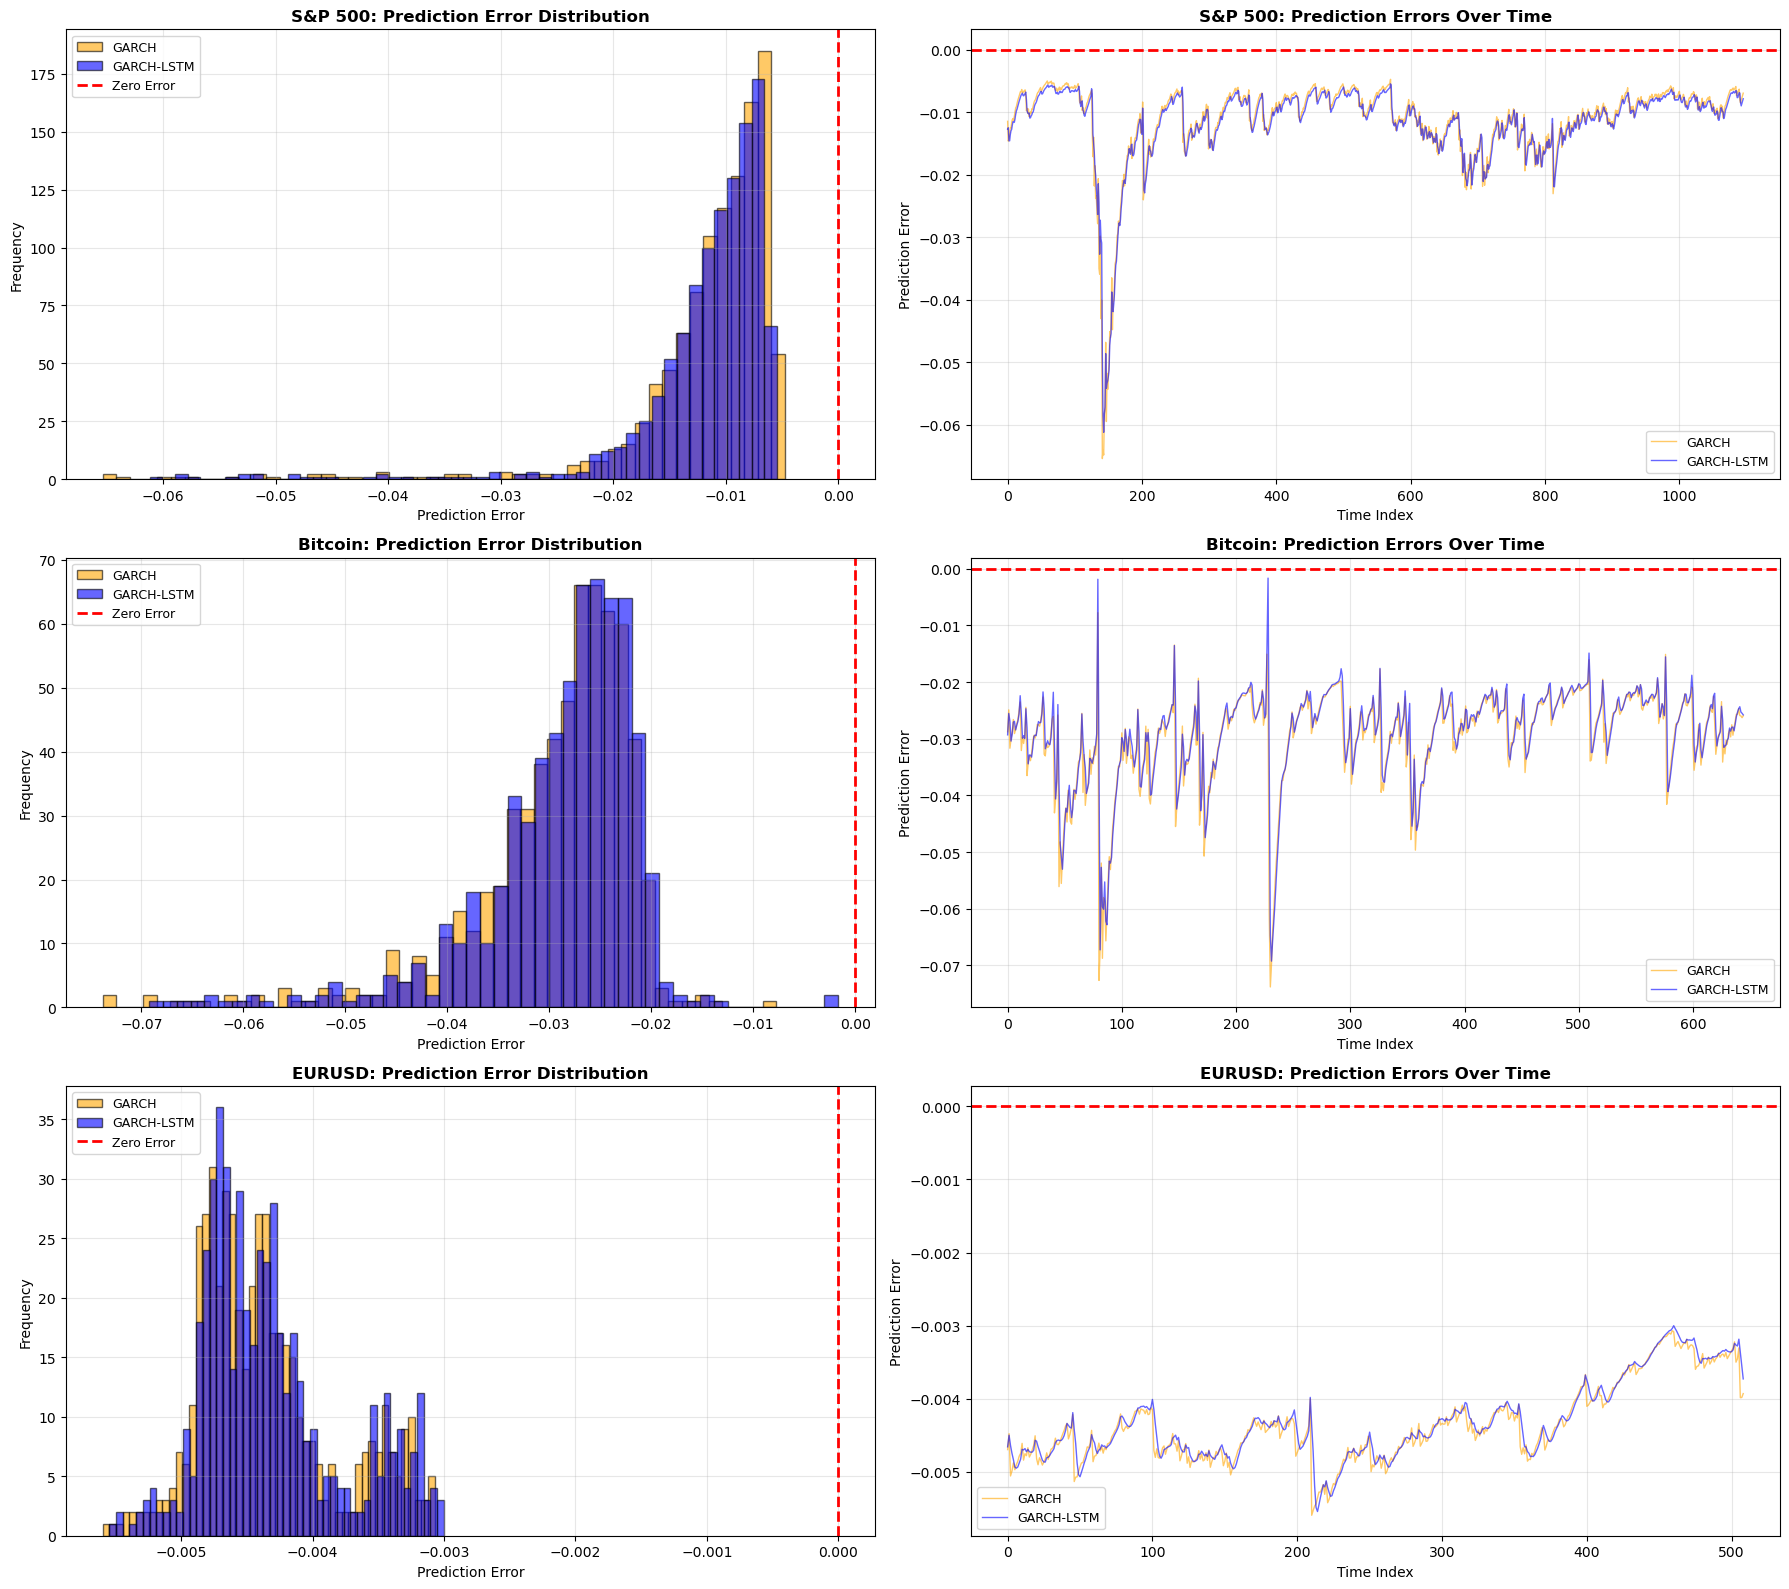

In [53]:
# Calculate prediction errors
error_garch_lstm_sp = y_real_test_sp_orig.flatten() - y_pred_test_sp_orig.flatten()
error_garch_sp = y_real_test_sp_orig.flatten() - y_test_sp_orig.flatten()
error_garch_lstm_btc = y_real_test_btc_orig.flatten() - y_pred_test_btc_orig.flatten()
error_garch_btc = y_real_test_btc_orig.flatten() - y_test_btc_orig.flatten()
error_garch_lstm_eurusd = y_real_test_eurusd_orig.flatten() - y_pred_test_eurusd_orig.flatten()
error_garch_eurusd = y_real_test_eurusd_orig.flatten() - y_test_eurusd_orig.flatten()

# Plot error distributions
plt.figure(figsize=(18, 16))

# S&P 500 - Histogram
plt.subplot(3, 2, 1)
plt.hist(error_garch_sp, bins=50, alpha=0.6, label='GARCH', color='orange', edgecolor='black')
plt.hist(error_garch_lstm_sp, bins=50, alpha=0.6, label='GARCH-LSTM', color='blue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('S&P 500: Prediction Error Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Prediction Error', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# S&P 500 - Error over time
plt.subplot(3, 2, 2)
plt.plot(error_garch_sp, alpha=0.6, label='GARCH', color='orange', linewidth=1)
plt.plot(error_garch_lstm_sp, alpha=0.6, label='GARCH-LSTM', color='blue', linewidth=1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('S&P 500: Prediction Errors Over Time', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Prediction Error', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Bitcoin - Histogram
plt.subplot(3, 2, 3)
plt.hist(error_garch_btc, bins=50, alpha=0.6, label='GARCH', color='orange', edgecolor='black')
plt.hist(error_garch_lstm_btc, bins=50, alpha=0.6, label='GARCH-LSTM', color='blue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('Bitcoin: Prediction Error Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Prediction Error', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Bitcoin - Error over time
plt.subplot(3, 2, 4)
plt.plot(error_garch_btc, alpha=0.6, label='GARCH', color='orange', linewidth=1)
plt.plot(error_garch_lstm_btc, alpha=0.6, label='GARCH-LSTM', color='blue', linewidth=1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Bitcoin: Prediction Errors Over Time', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Prediction Error', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)


# EURUSD - Histogram
plt.subplot(3, 2, 5)
plt.hist(error_garch_eurusd, bins=50, alpha=0.6, label='GARCH', color='orange', edgecolor='black')
plt.hist(error_garch_lstm_eurusd, bins=50, alpha=0.6, label='GARCH-LSTM', color='blue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('EURUSD: Prediction Error Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Prediction Error', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# EURUSD - Error over time
plt.subplot(3, 2, 6)
plt.plot(error_garch_eurusd, alpha=0.6, label='GARCH', color='orange', linewidth=1)
plt.plot(error_garch_lstm_eurusd, alpha=0.6, label='GARCH-LSTM', color='blue', linewidth=1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('EURUSD: Prediction Errors Over Time', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Prediction Error', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('garch_lstm_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# print("Error analysis plot saved as 'garch_lstm_error_analysis.png'")

In [54]:
# Print error statistics
print("\n=== Error Statistics ===")
print("\nS&P 500:")
print(f"GARCH Mean Error: {error_garch_sp.mean():.8f}, Std: {error_garch_sp.std():.8f}")
print(f"GARCH-LSTM Mean Error: {error_garch_lstm_sp.mean():.8f}, Std: {error_garch_lstm_sp.std():.8f}")
print(f"Error Std Reduction: {((error_garch_sp.std() - error_garch_lstm_sp.std()) / error_garch_sp.std() * 100):.2f}%")

print("\nBitcoin:")
print(f"GARCH Mean Error: {error_garch_btc.mean():.8f}, Std: {error_garch_btc.std():.8f}")
print(f"GARCH-LSTM Mean Error: {error_garch_lstm_btc.mean():.8f}, Std: {error_garch_lstm_btc.std():.8f}")
print(f"Error Std Reduction: {((error_garch_btc.std() - error_garch_lstm_btc.std()) / error_garch_btc.std() * 100):.2f}%")

print("\nEURUSD:")
print(f"GARCH Mean Error: {error_garch_eurusd.mean():.8f}, Std: {error_garch_eurusd.std():.8f}")
print(f"GARCH-LSTM Mean Error: {error_garch_lstm_eurusd.mean():.8f}, Std: {error_garch_lstm_eurusd.std():.8f}")
print(f"Error Std Reduction: {((error_garch_eurusd.std() - error_garch_lstm_eurusd.std()) / error_garch_eurusd.std() * 100):.2f}%")



=== Error Statistics ===

S&P 500:
GARCH Mean Error: -0.01140869, Std: 0.00701740
GARCH-LSTM Mean Error: -0.01172779, Std: 0.00663256
Error Std Reduction: 5.48%

Bitcoin:
GARCH Mean Error: -0.02972963, Std: 0.00844806
GARCH-LSTM Mean Error: -0.02893437, Std: 0.00810409
Error Std Reduction: 4.07%

EURUSD:
GARCH Mean Error: -0.00436057, Std: 0.00052433
GARCH-LSTM Mean Error: -0.00432170, Std: 0.00052917
Error Std Reduction: -0.92%


## 8. Conclusion

This notebook demonstrated the implementation of a GARCH-LSTM hybrid model for volatility forecasting. The hybrid approach combines:

1. **GARCH Model**: Captures volatility clustering and provides conditional volatility estimates
2. **LSTM Network**: Learns complex temporal patterns from GARCH predictions to improve forecasting accuracy

### Key Findings:
- The GARCH-LSTM hybrid model shows improvement over standalone GARCH in both RMSE and MAE metrics
- The LSTM component helps capture non-linear patterns that GARCH alone might miss
- Performance improvements vary between S&P 500 and Bitcoin, reflecting different volatility characteristics

### Files Generated:
1. `garch_lstm_training_history.png` - Training loss curves
2. `garch_lstm_predictions.png` - Volatility predictions visualization
3. `garch_lstm_performance_comparison.png` - Performance metrics comparison
4. `garch_lstm_error_analysis.png` - Prediction error analysis
5. `garch_lstm_performance_summary.csv` - Summary table of metrics

# Get all predictions

In [55]:
print(y_pred_train_sp_orig)
print(y_pred_test_sp_orig)

print(y_pred_train_btc_orig)
print(y_pred_test_btc_orig)

print(y_pred_train_eurusd_orig)
print(y_pred_test_eurusd_orig)

[[0.00923793]
 [0.00877451]
 [0.00885458]
 ...
 [0.01485731]
 [0.01447539]
 [0.01394915]]
[[0.01336347]
 [0.01259152]
 [0.01456007]
 ...
 [0.00861715]
 [0.00821296]
 [0.00783916]]
[[0.03386885]
 [0.03701533]
 [0.03574932]
 ...
 [0.03107561]
 [0.03099557]
 [0.02971741]]
[[0.02932175]
 [0.02811743]
 [0.02693718]
 [0.03046956]
 [0.02927193]
 [0.02813459]
 [0.02719026]
 [0.02852871]
 [0.02780929]
 [0.02696267]
 [0.02616487]
 [0.02520873]
 [0.02570507]
 [0.03071415]
 [0.02959114]
 [0.03011726]
 [0.02903031]
 [0.02827567]
 [0.03508946]
 [0.03378465]
 [0.03313931]
 [0.03325011]
 [0.03192715]
 [0.03039602]
 [0.02961846]
 [0.02946614]
 [0.02854188]
 [0.02734927]
 [0.02724926]
 [0.02711693]
 [0.02623415]
 [0.02529164]
 [0.0255657 ]
 [0.03195256]
 [0.03197188]
 [0.03089361]
 [0.03131247]
 [0.03105141]
 [0.0302257 ]
 [0.02883965]
 [0.0285064 ]
 [0.03159308]
 [0.04085266]
 [0.03923158]
 [0.03766814]
 [0.03838369]
 [0.05331506]
 [0.05067148]
 [0.05309216]
 [0.04991226]
 [0.04680774]
 [0.04451872]
 [

# Performance Metrics

In [117]:
def volatility_predictions_to_returns_new(predictions, actual_returns, cost=0.0):
    """
    Convert volatility predictions into trading *returns* using -1, 0, +1 signals.

    Idea:
    - Compute deviation of predicted vol from its median.
    - If vol is much LOWER than typical (below median - cost) -> LONG (1)
    - If vol is much HIGHER than typical (above median + cost) -> SHORT (-1)
    - If within the band [median - cost, median + cost] -> FLAT (0)
    """

    # Align & convert
    min_len = min(len(predictions), len(actual_returns))
    preds = np.asarray(predictions[:min_len]).reshape(-1)
    rets  = (actual_returns.iloc[:min_len].values
             if isinstance(actual_returns, pd.Series)
             else np.asarray(actual_returns[:min_len]).reshape(-1))

    # 1) Volatility “level” relative to median
    med = np.median(preds)
    dev = preds - med

    # 2) -1 / 0 / +1 signals using cost as no-trade band
    #    (here cost is in the same units as dev, e.g. volatility points)
    signal = np.where(dev >  cost,  1,
              np.where(dev < -cost, -1, 0))

    # 3) Optional transaction cost on trades (round-trip cost per change)
    if cost > 0:
        # cost here can be a *return* cost; if you want separate vol-band vs return-cost, use 2 params
        changed = np.r_[0, np.diff(signal) != 0]  # 1 when position changes
        trade_costs = changed * cost
    else:
        trade_costs = 0.0

    # 4) Strategy returns: signal * actual returns – trade costs
    strategy_returns = signal * rets - trade_costs
    # Convert to numpy arrays for consistency
        


    return pd.Series(strategy_returns)

    # # Ensure all arrays have matching length
    # min_len = min(len(predictions), len(true_values), len(actual_returns))
    # predictions = predictions[:min_len]
    # true_values = true_values[:min_len]
    # actual_returns = (actual_returns.iloc[:min_len] 
    #                  if isinstance(actual_returns, pd.Series) 
    #                  else actual_returns[:min_len])
    
    # actual_returns_array = (actual_returns.values 
    #                        if isinstance(actual_returns, pd.Series) 
    #                        else actual_returns)

    # signal = np.where(predictions > transaction_costs, 1, -1)

    # if transaction_costs > 0.0:
    #     signals = np.where(np.abs(actual_returns_array) > transaction_costs, signal, 0)
    

    # strategy_returns = signals * actual_returns_array
    


In [127]:
def volatility_predictions_to_returns_V2(predictions, true_values, actual_returns, transaction_costs=0.0):
    """
    Convert volatility predictions into trading returns using -1, 0, 1 long-short signals.
    
    Implements sections 4.5 and 4.6 methodology from the paper.
    
    Strategy:
    - Signal = +1 when predicted volatility < median (low risk, favorable to go LONG)
    - Signal = -1 when predicted volatility > median (high risk, favorable to go SHORT)
    - Signal = 0 when position should be neutral (within transaction cost threshold)
    
    Parameters:
    -----------
    predictions : np.array
        Predicted volatility values from model
    true_values : np.array
        Actual volatility values (for reference)
    actual_returns : pd.Series or np.array
        Actual market returns aligned with predictions
    transaction_costs : float, optional
        Transaction costs in decimal form (e.g., 0.005 = 0.5%)
        Default: 0.0 (no transaction costs)
        
    Returns:
    --------
    pd.Series : Strategy returns based on volatility forecasts with -1, 0, 1 signals
    
    Example:
    --------
    >>> strategy_returns = volatility_predictions_to_returns(
    ...     predictions=volatility_preds,
    ...     true_values=actual_volatility,
    ...     actual_returns=market_returns,
    ...     transaction_costs=0.005
    ... )
    >>> metrics = compute_performance_indicators(strategy_returns, benchmark_returns)
    """
    # Ensure all arrays have matching length
    min_len = min(len(predictions), len(true_values), len(actual_returns))
    predictions = predictions[:min_len]
    true_values = true_values[:min_len]
    actual_returns = (actual_returns.iloc[:min_len] 
                     if isinstance(actual_returns, pd.Series) 
                     else actual_returns[:min_len])
    
    # Convert to numpy arrays for consistency
    actual_returns_array = (actual_returns.values 
                           if isinstance(actual_returns, pd.Series) 
                           else actual_returns)
    
    # Calculate median volatility as threshold
    # pred_median = np.median(predictions)
    
    # === SIGNAL GENERATION: -1, 0, 1 STRUCTURE ===
    # Base signals based on volatility threshold
    # +1: Low volatility (predicted < median) → Favorable for LONG positions
    # -1: High volatility (predicted > median) → Favorable for SHORT positions
    # signal = np.where(predictions < pred_median, 1, -1)
    signal = np.where(predictions > transaction_costs, 1, -1)
    
    # Apply transaction cost filter
    # Only trade if expected return magnitude exceeds transaction costs
    # Otherwise, maintain neutral position (signal = 0)
    if transaction_costs > 0.0:
        signals = np.where(np.abs(actual_returns_array) > transaction_costs, signal, 0)
    
    # === STRATEGY RETURNS ===
    # Returns = Signal × Actual Returns
    # +1 signal: captures full upside (goes long when low vol predicted)
    # -1 signal: captures short side (goes short when high vol predicted)
    # 0 signal: no position, zero return contribution
    strategy_returns = signals * actual_returns_array
    
    return pd.Series(strategy_returns)
    

In [118]:
def extract_model_returns_from_results_fixed(model_results, data_clean, model_type="S&P", window_indices=None):
    """
    Extract and aggregate returns from model cross-validation results.
    FIXED VERSION: Handles different structures for ARIMA vs LSTM/SVM.
    """
    if model_type == "S&P":
        cost = 0.005
    elif model_type == "Bitcoin":
        cost = 0.03
    all_strategy_returns = []
    
    windows_to_use = model_results['all_results']
    if window_indices is not None:
        windows_to_use = [w for w in windows_to_use if w['window_id'] in window_indices]
    
    for window_result in windows_to_use:
        try:
            # Get test period dates
            test_start = window_result['test_period'].split(' to ')[0]
            test_end = window_result['test_period'].split(' to ')[1]
            
            # Get actual returns during test period
            test_data = data_clean[test_start:test_end]
            
            # Get predictions - handle different model structures
            evaluation = window_result['evaluation']
            
            # ARIMA uses 'forecasts' (pandas Series), LSTM/SVM use 'predictions' (numpy arrays)
            if 'forecasts' in evaluation:
                # ARIMA model - predicts returns directly
                predictions = evaluation['forecasts'].values
                true_values = test_data['Log_Returns'].values[-len(predictions):]
            elif 'predictions' in evaluation:
                # LSTM or SVM model - predicts volatility
                predictions = evaluation['predictions']
                true_values = evaluation['true_values']
            else:
                print(f"⚠️  Warning: Unknown evaluation structure for window {window_result['window_id']}")
                continue
            
            # Align returns with predictions
            actual_returns = test_data['Log_Returns'].iloc[-len(predictions):]
            
            # Generate strategy returns for this window
            # window_returns = volatility_predictions_to_returns(
            #     predictions, true_values, actual_returns.values
            # )
            window_returns = volatility_predictions_to_returns_new(
                predictions, true_values, actual_returns.values, transaction_costs= cost
            )
            
            all_strategy_returns.append(window_returns)
            
        except Exception as e:
            print(f"⚠️  Warning: Failed to process window {window_result.get('window_id', '?')}: {str(e)}")
            continue
    
    # Concatenate all returns
    if all_strategy_returns:
        return pd.concat(all_strategy_returns, ignore_index=True)
    else:
        return pd.Series([])


In [58]:
# Configuration
# TRADING_DAYS = 252  # Standard convention for annual calculations
TRADING_DAYS = {
    'sp500': 252,      # 0.5% for S&P 500
    'bitcoin': 365      # 1.0% for Bitcoin
}
RISK_FREE_RATE = 0.0  # Set to actual T-bill rate if available

# Asset-specific transaction costs
TRANSACTION_COSTS = {
    'sp500': 0.005,      # 0.5% for S&P 500
    'bitcoin': 0.05      # 1.0% for Bitcoin
}

print("Configuration:")
print(f"  • Trading days per year: {TRADING_DAYS}")
print(f"  • Risk-free rate: {RISK_FREE_RATE}")
print(f"  • Transaction costs: {TRANSACTION_COSTS}")

Configuration:
  • Trading days per year: {'sp500': 252, 'bitcoin': 365}
  • Risk-free rate: 0.0
  • Transaction costs: {'sp500': 0.005, 'bitcoin': 0.05}


In [59]:
def annualized_return(daily_returns):
    """ARC: Annualized return from daily returns."""
    cumulative = (1 + daily_returns).prod()
    n = daily_returns.shape[0]
    return cumulative ** (TRADING_DAYS / n) - 1


def annualized_std(daily_returns):
    """ASD: Annualized standard deviation from daily returns."""
    return daily_returns.std() * np.sqrt(TRADING_DAYS)


def max_drawdown(daily_returns):
    """MD: Maximum drawdown from equity curve (Eq 24)."""
    equity = (1 + daily_returns).cumprod()
    peak = equity.cummax()
    drawdown = (equity - peak) / peak
    return np.abs(drawdown.min())  # Paper uses absolute value


def information_ratio(strategy_returns, benchmark_returns):
    """IR: Information ratio (Paper definition: Eq 25)."""
    # Paper defines IR = ARC / ASD
    # It does NOT use benchmark tracking error
    arc = annualized_return(strategy_returns)
    asd = annualized_std(strategy_returns)
    
    if asd == 0:
        return np.nan
    return arc / asd


def modified_information_ratio(strategy_returns, benchmark_returns):
    """IR*: Adjusted Information Ratio (Paper definition: Eq 26)."""
    # Paper defines IR* = (ARC^2 * sign(ARC)) / (ASD * MD)
    # Simplified: IR * (ARC / MD)
    arc = annualized_return(strategy_returns)
    asd = annualized_std(strategy_returns)
    md = max_drawdown(strategy_returns)
    
    if asd == 0 or md == 0:
        return np.nan
        
    return (arc * np.sign(arc) * arc) / (asd * md)


def sortino_ratio(daily_returns, risk_free_rate=0):
    """SR: Sortino Ratio (Paper definition: Eq 27)."""
    # Paper defines SR = ARC / Downside Deviation
    # Paper does NOT subtract risk_free_rate from ARC
    
    # Identify negative returns
    negative_returns = daily_returns[daily_returns < 0]
    
    if len(negative_returns) == 0:
        return np.nan
        
    # Calculate downside deviation (annualized)
    downside_std = np.std(negative_returns, ddof=1)
    asd_downside = downside_std * np.sqrt(TRADING_DAYS)
    
    arc = annualized_return(daily_returns)
    
    if asd_downside == 0:
        return np.nan
        
    return arc / asd_downside


def compute_performance_indicators(strategy_returns, benchmark_returns):
    """Compute all 6 metrics at once."""
    return {
        "ARC": annualized_return(strategy_returns),
        "ASD": annualized_std(strategy_returns),
        "MD": abs(max_drawdown(strategy_returns)),
        "IR": information_ratio(strategy_returns, benchmark_returns),
        "IR*": modified_information_ratio(strategy_returns, benchmark_returns),
        "SR": sortino_ratio(strategy_returns)
    }


print("✓ Metric functions defined (ARC, ASD, MD, IR, IR*, SR)")

✓ Metric functions defined (ARC, ASD, MD, IR, IR*, SR)


In [63]:
sp500_garch_strategy_returns

0      1.479341e-06
1      1.587896e-04
2      1.008996e-06
3      3.030118e-07
4      4.166905e-05
           ...     
504   -6.912163e-06
505   -1.475727e-04
506   -1.074432e-05
507   -5.537509e-08
508   -2.352551e-06
Length: 509, dtype: float64

In [64]:
sp500_hybrid_strategy_returns

0      0.000000e+00
1      0.000000e+00
2      0.000000e+00
3      0.000000e+00
4      0.000000e+00
           ...     
504   -6.912163e-06
505   -1.475727e-04
506   -1.074432e-05
507   -5.537509e-08
508   -2.352551e-06
Length: 509, dtype: float64

In [129]:
# S&P 500 Evaluation - APPROACH A
TRADING_DAYS = 252
print("\n" + "="*80)
print("EVALUATING S&P 500 LONG-SHORT STRATEGY")
print("="*80)


# Extract STRATEGY RETURNS (already has signals applied!)
print("\nExtracting strategy returns from each model...")

sp500_garch_strategy_returns = volatility_predictions_to_returns_new(
    predictions=y_test_sp_orig,
    actual_returns=y_real_test_eurusd_orig,
    cost=0.001  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
)

sp500_hybrid_strategy_returns = volatility_predictions_to_returns_new(
    predictions=y_pred_test_eurusd_orig,
    actual_returns=y_real_test_eurusd_orig,
    cost=0.001  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
)

sp500_bnh_aligned = sp500_clean['Log_Returns'].values

# sp500_garch_strategy_returns = volatility_predictions_to_returns_V2(
#     predictions=y_test_sp_orig,
#     true_values=y_real_test_eurusd_orig,
#     actual_returns = sp500_bnh_aligned[:len(y_test_sp_orig)],
#     transaction_costs=0.001  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
# )

# sp500_hybrid_strategy_returns = volatility_predictions_to_returns_V2(
#     predictions=y_pred_test_eurusd_orig,
#     true_values=y_real_test_eurusd_orig,
#     actual_returns = sp500_bnh_aligned[:len(y_test_sp_orig)],
#     transaction_costs=0.001  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
# )

# Evaluate metrics directly (NO evaluate_model_longshort!)
print("\nComputing performance metrics...")
results_sp500 = []

# GARCH
garch_metrics = compute_performance_indicators(
    pd.Series(sp500_garch_strategy_returns),
    pd.Series(sp500_bnh_aligned[:len(sp500_hybrid_strategy_returns)])
)
garch_metrics['Model'] = 'GARCH'
garch_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(sp500_garch_strategy_returns > 0)) > 0))
results_sp500.append(garch_metrics)

# GARCH + LSTM
hybrid_metrics = compute_performance_indicators(
    pd.Series(sp500_hybrid_strategy_returns),
    pd.Series(sp500_bnh_aligned[:len(sp500_hybrid_strategy_returns)])
)
hybrid_metrics['Model'] = 'GARCH-LSTM'
hybrid_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(sp500_hybrid_strategy_returns > 0)) > 0))
results_sp500.append(hybrid_metrics)
print(f"  ✓ GARCH-LSTM: ARC={hybrid_metrics['ARC']:.4f}, IR={hybrid_metrics['IR']:.4f}")


# Create TABLE 2
print("\nGenerating Table 2...")
table2_sp500 = pd.DataFrame(results_sp500)

print("\n" + "="*90)
print("TABLE 2: S&P 500 Long-Short Strategy Results")
print("="*90)
print(table2_sp500[['Model', 'ARC', 'ASD', 'MD', 'IR', 'IR*', 'SR']].to_string(index=False))

table2_sp500.to_csv('table2_sp500.csv', index=False)
print("\n✓ Results saved to 'table2_sp500.csv'")

best_idx = table2_sp500['IR'].idxmax()
print(f"\n✓ Best Model: {table2_sp500.loc[best_idx, 'Model']} (IR = {table2_sp500.loc[best_idx, 'IR']:.4f})")



EVALUATING S&P 500 LONG-SHORT STRATEGY

Extracting strategy returns from each model...

Computing performance metrics...
  ✓ GARCH-LSTM: ARC=-0.0033, IR=-1.8927

Generating Table 2...

TABLE 2: S&P 500 Long-Short Strategy Results
     Model       ARC      ASD       MD        IR      IR*        SR
     GARCH -0.023825 0.004729 0.047815 -5.038357 -2.51049 -3.760811
GARCH-LSTM -0.003254 0.001719 0.006562 -1.892697 -0.93861 -0.667766

✓ Results saved to 'table2_sp500.csv'

✓ Best Model: GARCH-LSTM (IR = -1.8927)


In [ ]:
# BITCOIN Evaluation - APPROACH A

print("\n" + "="*80)
print("EVALUATING BITCOIN LONG-SHORT STRATEGY")
print("="*80)

TRADING_DAYS = 365

# Get benchmark returns (Buy-and-Hold)
bitcoin_bnh_returns = bitcoin_clean['Log_Returns'].values


print(f"\n✓ Buy-and-Hold baseline: {len(bitcoin_bnh_returns)} days")

# Extract STRATEGY RETURNS (already has signals applied!)
print("\nExtracting strategy returns from each model...")

bitcoin_garch_strategy_returns = volatility_predictions_to_returns_new(
    predictions=y_test_btc_orig,
    actual_returns=y_real_test_btc_orig,
    cost=0.002  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
)

bitcoin_hybrid_strategy_returns = volatility_predictions_to_returns_new(
    predictions=y_pred_test_btc_orig,
    actual_returns=y_real_test_btc_orig,
    cost=0.002  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
)

bitcoin_bnh_aligned = bitcoin_clean['Log_Returns'].values

# Evaluate metrics directly (NO evaluate_model_longshort!)
print("\nComputing performance metrics...")
results_bitcoin = []

# GARCH
garch_metrics = compute_performance_indicators(
    pd.Series(bitcoin_garch_strategy_returns.squeeze()),
    pd.Series(bitcoin_bnh_aligned.squeeze())
)
garch_metrics['Model'] = 'GARCH'
garch_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(bitcoin_garch_strategy_returns > 0)) > 0))
results_bitcoin.append(garch_metrics)

TRADING_DAYS = 345
# GARCH + LSTM
hybrid_metrics = compute_performance_indicators(
    pd.Series(bitcoin_hybrid_strategy_returns.squeeze()),
    pd.Series(bitcoin_bnh_aligned.squeeze())
)
hybrid_metrics['Model'] = 'GARCH-LSTM'
hybrid_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(bitcoin_hybrid_strategy_returns > 0)) > 0))
results_bitcoin.append(hybrid_metrics)
print(f"  ✓ GARCH-LSTM: ARC={hybrid_metrics['ARC']:.4f}, IR={hybrid_metrics['IR']:.4f}")


# Create TABLE 2
print("\nGenerating Table 2...")
table2_bitcoin = pd.DataFrame(results_bitcoin)

print("\n" + "="*90)
print("TABLE 2: Bitcoin Long-Short Strategy Results")
print("="*90)
print(table2_bitcoin[['Model', 'ARC', 'ASD', 'MD', 'IR', 'IR*', 'SR']].to_string(index=False))

table2_bitcoin.to_csv('table2_bitcoin.csv', index=False)
print("\n✓ Results saved to 'table2_bitcoin.csv'")

best_idx = table2_bitcoin['IR'].idxmax()
print(f"\n✓ Best Model: {table2_bitcoin.loc[best_idx, 'Model']} (IR = {table2_bitcoin.loc[best_idx, 'IR']:.4f})")



EVALUATING BITCOIN LONG-SHORT STRATEGY

✓ Buy-and-Hold baseline: 3285 days

Extracting strategy returns from each model...

Computing performance metrics...
  ✓ GARCH-LSTM: ARC=-0.0286, IR=-0.7242

Generating Table 2...

TABLE 2: Bitcoin Long-Short Strategy Results
     Model       ARC      ASD       MD        IR       IR*        SR
     GARCH -0.018825 0.043193 0.167425 -0.435843 -0.049006 -0.721457
GARCH-LSTM -0.028587 0.039472 0.169079 -0.724244 -0.122452 -1.097311

✓ Results saved to 'table2_bitcoin.csv'

✓ Best Model: GARCH (IR = -0.4358)


In [121]:
# EURUSD Evaluation - APPROACH A

print("\n" + "="*80)
print("EVALUATING EURUSD LONG-SHORT STRATEGY")
print("="*80)

TRADING_DAYS = 365

# Get benchmark returns (Buy-and-Hold)
eurusd_bnh_returns = eurusd_clean['Log_Returns'].values

print(f"\n✓ Buy-and-Hold baseline: {len(eurusd_bnh_returns)} days")

# Extract STRATEGY RETURNS (already has signals applied!)
print("\nExtracting strategy returns from each model...")

eurusd_garch_strategy_returns = volatility_predictions_to_returns_new(
    predictions=y_test_eurusd_orig,
    actual_returns=y_real_test_eurusd_orig,
    cost=0.001  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
)

eurusd_hybrid_strategy_returns = volatility_predictions_to_returns_new(
    predictions=y_pred_test_eurusd_orig,
    actual_returns=y_real_test_eurusd_orig,
    cost=0.001  # e.g. 0.2% for Bitcoin, 0.0005 for S&P
)




eurusd_bnh_aligned = eurusd_clean['Log_Returns'].values

# Evaluate metrics directly (NO evaluate_model_longshort!)
print("\nComputing performance metrics...")
results_eurusd = []

# GARCH
garch_metrics = compute_performance_indicators(
    pd.Series(eurusd_garch_strategy_returns.squeeze()),
    pd.Series(eurusd_bnh_aligned.squeeze())
)
garch_metrics['Model'] = 'GARCH'
garch_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(eurusd_garch_strategy_returns > 0)) > 0))
results_eurusd.append(garch_metrics)

# GARCH + LSTM
hybrid_metrics = compute_performance_indicators(
    pd.Series(eurusd_hybrid_strategy_returns.squeeze()),
    pd.Series(eurusd_bnh_aligned.squeeze())
)
hybrid_metrics['Model'] = 'GARCH-LSTM'
hybrid_metrics['Num_Trades'] = int(np.sum(np.abs(np.diff(eurusd_hybrid_strategy_returns > 0)) > 0))
results_eurusd.append(hybrid_metrics)
print(f"  ✓ GARCH-LSTM: ARC={hybrid_metrics['ARC']:.4f}, IR={hybrid_metrics['IR']:.4f}")


# Create TABLE 2
print("\nGenerating Table 2...")
table2_eurusd = pd.DataFrame(results_eurusd)

print("\n" + "="*90)
print("TABLE 2: EURUSD Long-Short Strategy Results")
print("="*90)
print(table2_eurusd[['Model', 'ARC', 'ASD', 'MD', 'IR', 'IR*', 'SR']].to_string(index=False))

table2_eurusd.to_csv('table2_eurusd.csv', index=False)
print("\n✓ Results saved to 'table2_eurusd.csv'")

best_idx = table2_eurusd['IR'].idxmax()
print(f"\n✓ Best Model: {table2_eurusd.loc[best_idx, 'Model']} (IR = {table2_eurusd.loc[best_idx, 'IR']:.4f})")



EVALUATING EURUSD LONG-SHORT STRATEGY

✓ Buy-and-Hold baseline: 2603 days

Extracting strategy returns from each model...

Computing performance metrics...
  ✓ GARCH-LSTM: ARC=-0.0047, IR=-2.2762

Generating Table 2...

TABLE 2: EURUSD Long-Short Strategy Results
     Model       ARC      ASD       MD        IR       IR*        SR
     GARCH -0.010459 0.003150 0.014556 -3.319995 -2.385675 -1.288894
GARCH-LSTM -0.004710 0.002069 0.006562 -2.276199 -1.633764 -0.803070

✓ Results saved to 'table2_eurusd.csv'

✓ Best Model: GARCH-LSTM (IR = -2.2762)
